In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta

# print(plt.style.available) #list of available styles
#plt.style.use('ggplot')
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
def calc_regresion(r_ind, r):
    res = []
    summary = []
    
    for activo in r.columns:
        X = r_ind
        y = r[activo]
        X_sm = sm.add_constant(X)
        
        modelo = sm.OLS(y, X_sm).fit()
        
        resultado = {
        'activo': activo,
        'alpha': modelo.params[0],
        'beta': modelo.params[1],
        'p_value_alpha': modelo.pvalues[0],
        'p_value_beta': modelo.pvalues[1],
        't_value_alpha': modelo.tvalues[0],
        't_value_beta': modelo.tvalues[1],
        'rsquared': modelo.rsquared,
        'fvalue': modelo.fvalue,
        'conf_int_alpha_low': modelo.conf_int()[0][0],
        'conf_int_alpha_high': modelo.conf_int()[0][1],
        'conf_int_beta_low': modelo.conf_int()[1][0],
        'conf_int_beta_high': modelo.conf_int()[1][1],
        'aic': modelo.aic,
        'bic': modelo.bic
        }
        
        res.append(resultado)
        summary.append(modelo.summary())
        
    df_resul = pd.DataFrame(res)
    df_resul = df_resul.set_index('activo')
    
    df_summ = pd.DataFrame(summary)
    df_summ.index = r.columns
    
    return df_resul, df_summ

In [33]:
def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free  # Ajuste por la tasa libre de riesgo aquí es correcto
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside))  # Asegúrate de anualizar si es necesario

def sortino(returns, risk_free=0):
    if isinstance(returns, pd.DataFrame):
        # Utiliza una función lambda para pasar correctamente risk_free a la función sortino
        # cuando se llama desde un DataFrame.
        return returns.apply(lambda x: sortino(x, risk_free), axis=0)
    elif isinstance(returns, pd.Series):
        drisk = downside_risk(returns, risk_free)

        if drisk == 0:
            return np.nan

        adj_returns = returns - risk_free
        mean_return = np.nanmean(adj_returns)  # Calcula la media de adj_returns

        return mean_return / drisk
    
    else:
        raise TypeError("Esperamos una Serie o DataFrame")


In [34]:
def max_drawdown(prices):
    drawdowns = precios / precios.cummax() - 1
    max_draw = drawdowns.min()

    return max_draw

In [35]:
# Nos bajamoslos precios diarios del SP500 y calculamos los precios semanales, mensuales, trimestrales y anuales

start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Adj Close"]] # Precios ajustados al cierre
ret_indice_sp500 = np.log(precios_indice).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [36]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['BRK.B', 'CDAY']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-01 -> 2024-04-11)')


In [37]:
precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

rf = 0.01/252

In [38]:
ret_activos_sp500.head(2)

Ticker,AAPL,ABT,ADBE,ADI,ADM,ADP,ADSK,AEP,AES,AFL,...,WMB,WMT,WRB,WST,WY,XEL,XOM,XRAY,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-04,0.025726,0.000000,-0.027869,-0.026567,0.006154,-0.004283,0.029656,0.011342,0.026317,0.030772,...,0.024451,0.035298,-0.016806,-0.004576,-0.022765,0.002821,0.004116,0.000000,-0.013423,-0.019147
1995-01-05,-0.012782,-0.007663,0.038384,0.009569,-0.012345,0.006417,0.000000,0.000000,0.000000,-0.003796,...,0.014389,0.011494,0.000000,0.009133,0.019544,0.002814,0.002051,0.003929,0.000000,0.008749


In [39]:
riesgo_df = pd.DataFrame(index= ret_activos_sp500.columns)

In [40]:
riesgo_df['mean'] = ret_activos_sp500.mean()
riesgo_df['std'] = ret_activos_sp500.std()
riesgo_df['skew'] = ret_activos_sp500.skew()
riesgo_df['kurt'] = ret_activos_sp500.kurt()


In [41]:
riesgo_df['sharpe'] = (riesgo_df['mean']-rf) / riesgo_df['std']

In [42]:
df_all_res, df_all_summary = calc_regresion(ret_indice_sp500, ret_activos_sp500)

In [43]:
# Son las betas significativas?
(df_all_res['p_value_beta'] > 0.05).sum()


0

In [44]:
riesgo_df['beta'] = df_all_res['beta']


In [45]:
riesgo_df['sortino'] = sortino(ret_activos_sp500, risk_free=rf)

In [46]:
riesgo_df['treynor'] = (riesgo_df['mean']-rf)/(riesgo_df['beta'])

In [47]:
riesgo_df['max_dd'] = max_drawdown(precios_activos_sp500)

In [48]:
indices_positivos = ret_indice_sp500[ret_indice_sp500>0].dropna().index
indices_negativos = ret_indice_sp500[ret_indice_sp500<=0].dropna().index

In [49]:
ret_indice_sp500_pos = ret_indice_sp500.loc[indices_positivos]
ret_indice_sp500_neg = ret_indice_sp500.loc[indices_negativos]
ret_activos_sp500_pos = ret_activos_sp500.loc[indices_positivos]
ret_activos_sp500_neg = ret_activos_sp500.loc[indices_negativos]

In [50]:
df_all_res_pos, df_all_summary_pos = calc_regresion(ret_indice_sp500_pos, ret_activos_sp500_pos)
df_all_res_neg, df_all_summary_neg = calc_regresion(ret_indice_sp500_neg, ret_activos_sp500_neg)

In [51]:
riesgo_df['bull_beta'] = df_all_res_pos['beta']
riesgo_df['bear_beta'] = df_all_res_neg['beta']

In [52]:
riesgo_df.head(2)

,mean,std,skew,kurt,sharpe,beta,sortino,treynor,max_dd,bull_beta,bear_beta
Ticker,,,,,,,,,,,
AAPL,0.000865,0.027337,-2.431843,75.507271,0.030182,1.105488,0.041899,0.000746,-0.818014,1.073880,1.075070
ABT,0.000457,0.015634,-0.264607,7.053524,0.026671,0.665524,0.037864,0.000627,-0.456648,0.638612,0.632482


Text(0.5, 1.0, 'Bull vs Bear Beta')

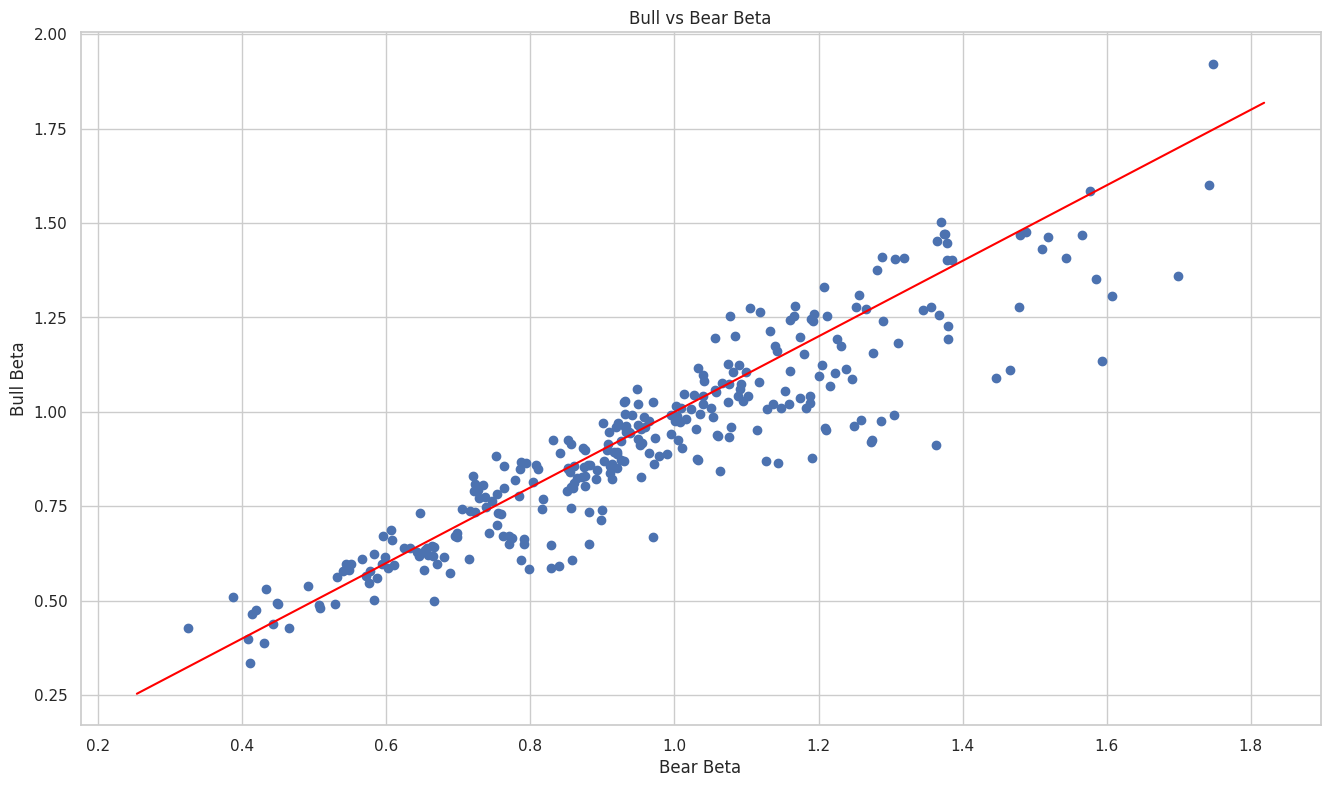

In [56]:
plt.scatter( riesgo_df['bear_beta'], riesgo_df['bull_beta'])
plt.ylabel('Bull Beta')
plt.xlabel('Bear Beta')

# Añadir la recta y=x
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red')  
plt.title('Bull vs Bear Beta')

In [ ]:
riesgo_df['var95'] = ret_activos_sp500.quantile(0.05)

<Axes: >

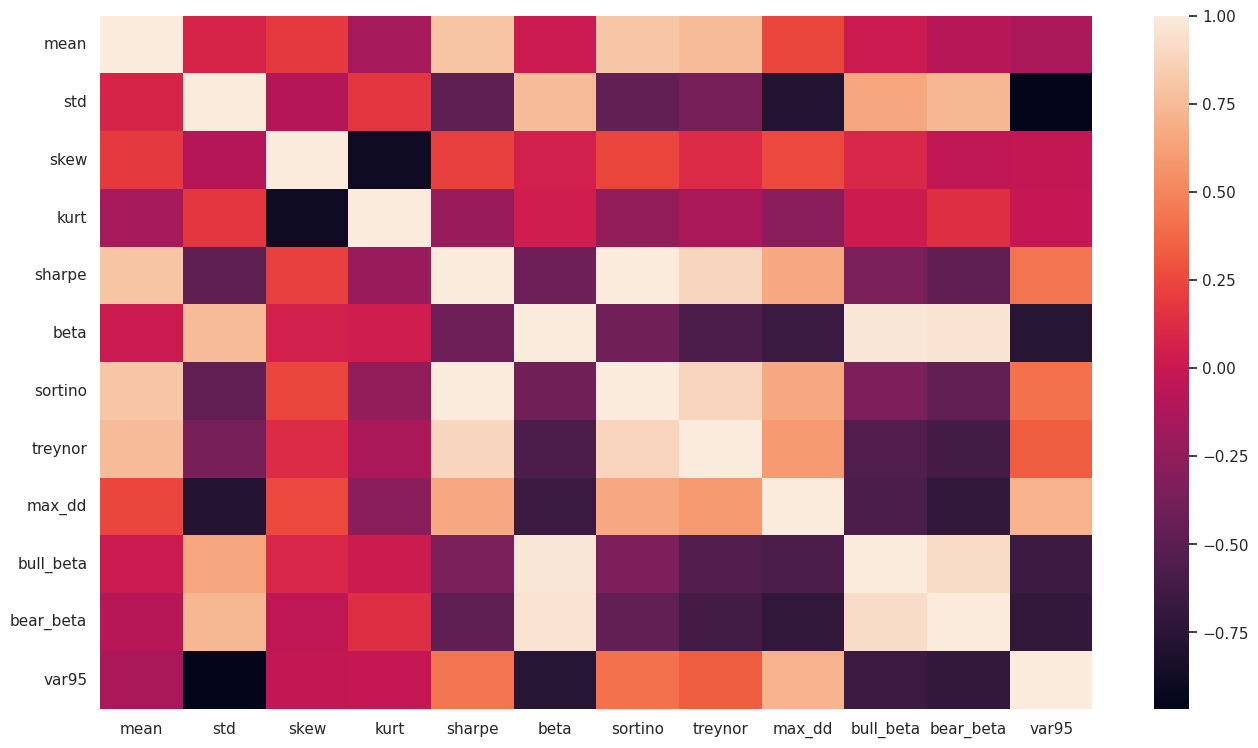

In [ ]:
sns.heatmap(riesgo_df.corr())